In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000607,-0.001033,0.001586,0.003769,-0.000243,-0.000310,0.001519,-0.004942,-0.002082,...,-0.004942,0.000056,-0.001784,-0.134213,-0.010852,0.009912,-0.153644,-0.045258,-0.150407,-0.232084
1,-1.027122,0.048423,-0.002944,-0.000262,0.021788,-0.000289,-0.000408,0.001519,-0.017760,-0.002090,...,-0.017760,0.000042,-0.015981,-0.134199,-0.010853,0.009911,-0.153644,-0.045258,-0.150407,-0.191414
2,-1.027122,0.146858,-0.000820,0.001179,0.005336,0.000219,0.000182,0.001882,-0.003509,-0.002079,...,-0.003509,0.000060,-0.004908,-0.133998,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.044781
3,-1.027122,0.095208,-0.000137,0.002144,-0.003282,-0.000302,-0.000333,0.001519,0.001063,-0.002076,...,0.001063,0.000066,0.002495,-0.133893,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.088803
4,-1.027122,0.078927,-0.000084,0.001453,-0.000148,-0.000061,-0.000199,0.001519,0.001425,-0.002077,...,0.001425,0.000064,-0.002813,-0.133738,-0.010855,0.009909,-0.153644,-0.045258,-0.150406,-0.099000


In [4]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(26697608, 23)

In [5]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [6]:
M1.shape, M2.shape

((26697608, 10), (26697608, 13))

In [8]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [125]:
dt = M1_104
dt_name = namestr(M1_104, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [126]:
dt.head()

,Ux,Uy,Uz,S1,S2,S3,S4,S5,S6,Cs
0,-0.001173,-0.000731,0.000361,-0.000859,0.000819,-0.000810,-0.001709,0.001019,0.001444,-1.929617
1,0.014881,-0.001335,-0.000416,0.007403,0.000857,-0.000455,-0.004601,0.001303,-0.002616,-0.183021
2,0.073479,-0.001803,-0.001557,0.015995,0.000920,-0.000355,-0.008244,-0.000530,-0.010018,-0.124142
3,0.144117,-0.000242,-0.000506,0.011368,0.000995,-0.000283,-0.001409,-0.002066,-0.005366,-0.258416
4,0.145522,0.000837,0.001413,-0.009122,-0.000244,-0.001325,0.004366,-0.002363,0.004082,0.106165


In [127]:
#dt.to_csv(f'./{dt_name}.txt', sep=' ', index=False, encoding='utf-8', header=False)

In [128]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [129]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((17552029, 10), 11232182, 2809090, 3510757)

In [130]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [131]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 0.0215, -0.0596, -0.0436,  0.0107, -0.0060, -0.0044, -0.0152, -0.0029,
         0.0047,  0.0132], dtype=torch.float64)

In [132]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [133]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [134]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_layers, neurons_per_layer):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        encoder_layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            encoder_layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(neurons_per_layer[-1], latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_size, neurons_per_layer[-1]))
        decoder_layers.append(nn.ReLU())

        for i in range(hidden_layers - 1, 0, -1):
            decoder_layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i - 1]))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(neurons_per_layer[0], 1))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)

        # Decode
        decoded = self.decoder(encoded)

        return decoded


In [135]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

In [136]:
#model = Autoencoder(input_size, latent_size, hidden_layers, neurons_per_layer)

In [137]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

In [138]:
#criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [139]:
device = torch.device("cuda")
model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=9, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [140]:
class EarlyStopper:
    def __init__(self, patience=1, path=None):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, model_stat, val_loss):
        if val_loss < self.min_val_loss:
            torch.save(model_stat, self.path)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + sys_epsilon):
            self.counter += 1
            if self.counter >= self.patience:
                print('+++ Early Stopping is reached! +++')
                return True
        return False

In [ ]:
epochs = 6000
best = 1e6
PATH = f"./best_model_{dt_name}.pt"

early_stopper = EarlyStopper(patience=50, path=PATH)
                             
for epoch in range(epochs):
    model.train()
    Loss_train = 0 
    Loss_val = 0
    coeff_train = 0
    coeff_val = 0
    with tqdm(train_loader, unit="batch") as trainer:
        for batch in trainer:
            trainer.set_description("Train")
            train_feat = batch[:, 0:-1].to(device)
            train_labs = batch[:, -1].to(device)
            train_pred = model(train_feat).squeeze()
            train_loss = torch.nn.functional.mse_loss(train_pred, train_labs)
            train_coef = coeff_determination(train_labs, train_labs) 

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            Loss_train += train_loss.item()
            coeff_train += train_coef

        Loss_train /= batch_sz_trn
        coeff_train /= batch_sz_trn

    model.eval()
    with tqdm(val_loader, unit="batch") as validator:
        for batch in validator:
            validator.set_description("Valdt")
            val_feat = batch[:, 0:-1].to(device)
            val_labs = batch[:, -1].to(device)
            val_pred = model(val_feat).squeeze()
            val_loss = torch.nn.functional.mse_loss(val_pred, val_labs)
            val_coef = coeff_determination(val_labs, val_labs) 

            Loss_val += val_loss.item()
            coeff_val += val_coef

        Loss_val /= batch_sz_val
        coeff_val /= batch_sz_val
    
    if early_stopper.early_stop(model.state_dict(), Loss_val):             
        break
        
    print(f"Epoch: {epoch} / {epochs}, \n Train -- Loss: {Loss_train}, Coeff: {coeff_train} \n Val   -- Loss: {Loss_val}, Coeff: {coeff_val} \n\n")

Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.23batch/s]


Epoch: 0 / 6000, 
 Train -- Loss: 0.5884371118407569, Coeff: 0.669677734375 
 Val   -- Loss: 2.2834882203564333, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.35batch/s]


Epoch: 1 / 6000, 
 Train -- Loss: 0.5592006475739323, Coeff: 0.669677734375 
 Val   -- Loss: 2.2130041130420706, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 236.34batch/s]


Epoch: 2 / 6000, 
 Train -- Loss: 0.5439459267282887, Coeff: 0.669677734375 
 Val   -- Loss: 2.178012155843449, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 226.96batch/s]


Epoch: 3 / 6000, 
 Train -- Loss: 0.5321203340485706, Coeff: 0.669677734375 
 Val   -- Loss: 2.1317774424721647, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.24batch/s]


Epoch: 4 / 6000, 
 Train -- Loss: 0.5209815212768225, Coeff: 0.669677734375 
 Val   -- Loss: 2.080254981249352, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 234.90batch/s]


Epoch: 5 / 6000, 
 Train -- Loss: 0.5093753791247237, Coeff: 0.669677734375 
 Val   -- Loss: 2.0439745088384473, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.50batch/s]


Epoch: 6 / 6000, 
 Train -- Loss: 0.5020647877748575, Coeff: 0.669677734375 
 Val   -- Loss: 2.023868609133873, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.64batch/s]


Epoch: 7 / 6000, 
 Train -- Loss: 0.4966791435875693, Coeff: 0.669677734375 
 Val   -- Loss: 2.035607810094873, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.57batch/s]


Epoch: 8 / 6000, 
 Train -- Loss: 0.49087362825916486, Coeff: 0.669677734375 
 Val   -- Loss: 2.022157244923745, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 236.10batch/s]


Epoch: 9 / 6000, 
 Train -- Loss: 0.48816891216347574, Coeff: 0.669677734375 
 Val   -- Loss: 1.9900439833264634, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.20batch/s]


Epoch: 10 / 6000, 
 Train -- Loss: 0.48580059778213835, Coeff: 0.669677734375 
 Val   -- Loss: 2.0004950797821257, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.82batch/s]


Epoch: 11 / 6000, 
 Train -- Loss: 0.4829332936614367, Coeff: 0.669677734375 
 Val   -- Loss: 1.9680773642317173, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 234.52batch/s]


Epoch: 12 / 6000, 
 Train -- Loss: 0.48043449091816337, Coeff: 0.669677734375 
 Val   -- Loss: 1.9719803538403478, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.62batch/s]


Epoch: 13 / 6000, 
 Train -- Loss: 0.47765755201832905, Coeff: 0.669677734375 
 Val   -- Loss: 1.9720213158630282, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.51batch/s]


Epoch: 14 / 6000, 
 Train -- Loss: 0.4764293302570788, Coeff: 0.669677734375 
 Val   -- Loss: 1.9581981817255458, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.01batch/s]


Epoch: 15 / 6000, 
 Train -- Loss: 0.47475814197784977, Coeff: 0.669677734375 
 Val   -- Loss: 1.9514808905461698, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.09batch/s]


Epoch: 16 / 6000, 
 Train -- Loss: 0.472539783015586, Coeff: 0.669677734375 
 Val   -- Loss: 1.9377894056429135, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 233.48batch/s]


Epoch: 17 / 6000, 
 Train -- Loss: 0.4706293552022152, Coeff: 0.669677734375 
 Val   -- Loss: 1.965721219413614, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 233.69batch/s]


Epoch: 18 / 6000, 
 Train -- Loss: 0.46982803813518403, Coeff: 0.669677734375 
 Val   -- Loss: 1.928112128037997, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.22batch/s]


Epoch: 19 / 6000, 
 Train -- Loss: 0.46757758768878177, Coeff: 0.669677734375 
 Val   -- Loss: 1.9573723501823754, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.78batch/s]


Epoch: 20 / 6000, 
 Train -- Loss: 0.4663070515024854, Coeff: 0.669677734375 
 Val   -- Loss: 1.9486722095744424, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.73batch/s]


Epoch: 21 / 6000, 
 Train -- Loss: 0.4652680872861983, Coeff: 0.669677734375 
 Val   -- Loss: 1.9409566786816859, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.37batch/s]


Epoch: 22 / 6000, 
 Train -- Loss: 0.46388711778266223, Coeff: 0.669677734375 
 Val   -- Loss: 1.971509669388248, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 233.32batch/s]


Epoch: 23 / 6000, 
 Train -- Loss: 0.4635460129608638, Coeff: 0.669677734375 
 Val   -- Loss: 1.9311043145556164, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.46batch/s]


Epoch: 24 / 6000, 
 Train -- Loss: 0.46206893379075453, Coeff: 0.669677734375 
 Val   -- Loss: 1.9294411611044253, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.87batch/s]


Epoch: 25 / 6000, 
 Train -- Loss: 0.46142675031721825, Coeff: 0.669677734375 
 Val   -- Loss: 1.9226596412339312, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.96batch/s]


Epoch: 26 / 6000, 
 Train -- Loss: 0.4588513424096295, Coeff: 0.669677734375 
 Val   -- Loss: 1.9184990787085783, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.98batch/s]


Epoch: 27 / 6000, 
 Train -- Loss: 0.4594111478027946, Coeff: 0.669677734375 
 Val   -- Loss: 1.9360819177297206, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.84batch/s]


Epoch: 28 / 6000, 
 Train -- Loss: 0.4592949276127379, Coeff: 0.669677734375 
 Val   -- Loss: 2.0065130893958587, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.80batch/s]


Epoch: 29 / 6000, 
 Train -- Loss: 0.4572975057377149, Coeff: 0.669677734375 
 Val   -- Loss: 1.9218706331425097, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.05batch/s]


Epoch: 30 / 6000, 
 Train -- Loss: 0.4562808892496251, Coeff: 0.669677734375 
 Val   -- Loss: 1.9102841758351607, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.37batch/s]


Epoch: 31 / 6000, 
 Train -- Loss: 0.45596610435186946, Coeff: 0.669677734375 
 Val   -- Loss: 1.9386024481812025, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.44batch/s]


Epoch: 32 / 6000, 
 Train -- Loss: 0.4553308963299435, Coeff: 0.669677734375 
 Val   -- Loss: 1.9236994784990713, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.33batch/s]


Epoch: 33 / 6000, 
 Train -- Loss: 0.4550750907878453, Coeff: 0.669677734375 
 Val   -- Loss: 1.9162217463511164, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 225.58batch/s]


Epoch: 34 / 6000, 
 Train -- Loss: 0.4539128353068443, Coeff: 0.669677734375 
 Val   -- Loss: 1.9168887831850725, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.94batch/s]


Epoch: 35 / 6000, 
 Train -- Loss: 0.4519714408504082, Coeff: 0.669677734375 
 Val   -- Loss: 1.912318499321486, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.97batch/s]


Epoch: 36 / 6000, 
 Train -- Loss: 0.4512486924089849, Coeff: 0.669677734375 
 Val   -- Loss: 1.9369793767105379, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.04batch/s]


Epoch: 37 / 6000, 
 Train -- Loss: 0.4504978350549369, Coeff: 0.669677734375 
 Val   -- Loss: 1.9150304137277503, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.05batch/s]


Epoch: 38 / 6000, 
 Train -- Loss: 0.4495411933229672, Coeff: 0.669677734375 
 Val   -- Loss: 1.9157659075288327, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.47batch/s]


Epoch: 39 / 6000, 
 Train -- Loss: 0.45033651689848087, Coeff: 0.669677734375 
 Val   -- Loss: 1.9207261476982902, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 238.29batch/s]


Epoch: 40 / 6000, 
 Train -- Loss: 0.45013428809133954, Coeff: 0.669677734375 
 Val   -- Loss: 1.9190137301992916, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.04batch/s]


Epoch: 41 / 6000, 
 Train -- Loss: 0.44935886782285417, Coeff: 0.669677734375 
 Val   -- Loss: 1.8994366857853098, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.72batch/s]


Epoch: 42 / 6000, 
 Train -- Loss: 0.4489421531730768, Coeff: 0.669677734375 
 Val   -- Loss: 1.9186797638743711, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.41batch/s]


Epoch: 43 / 6000, 
 Train -- Loss: 0.446966401886963, Coeff: 0.669677734375 
 Val   -- Loss: 1.8972953446086787, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 223.02batch/s]


Epoch: 44 / 6000, 
 Train -- Loss: 0.4480124757683976, Coeff: 0.669677734375 
 Val   -- Loss: 1.9435463602944285, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 225.97batch/s]


Epoch: 45 / 6000, 
 Train -- Loss: 0.4458098611054227, Coeff: 0.669677734375 
 Val   -- Loss: 1.8980840591480026, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.28batch/s]


Epoch: 46 / 6000, 
 Train -- Loss: 0.4445472373429274, Coeff: 0.669677734375 
 Val   -- Loss: 1.9037406031417439, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.87batch/s]


Epoch: 47 / 6000, 
 Train -- Loss: 0.44465444552116357, Coeff: 0.669677734375 
 Val   -- Loss: 1.9224908441560151, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 233.53batch/s]


Epoch: 48 / 6000, 
 Train -- Loss: 0.4440391488196124, Coeff: 0.669677734375 
 Val   -- Loss: 1.9391729154559678, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.21batch/s]


Epoch: 49 / 6000, 
 Train -- Loss: 0.4437602280383506, Coeff: 0.669677734375 
 Val   -- Loss: 1.9111499296038852, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 225.62batch/s]


Epoch: 50 / 6000, 
 Train -- Loss: 0.4437486265167754, Coeff: 0.669677734375 
 Val   -- Loss: 1.9090253071762797, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.60batch/s]


Epoch: 51 / 6000, 
 Train -- Loss: 0.44248580240163427, Coeff: 0.669677734375 
 Val   -- Loss: 1.8973211012669522, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.85batch/s]


Epoch: 52 / 6000, 
 Train -- Loss: 0.44253776621055535, Coeff: 0.669677734375 
 Val   -- Loss: 1.9061973591596226, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.26batch/s]


Epoch: 53 / 6000, 
 Train -- Loss: 0.443011761137675, Coeff: 0.669677734375 
 Val   -- Loss: 1.928689067599372, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.06batch/s]


Epoch: 54 / 6000, 
 Train -- Loss: 0.4415085042554444, Coeff: 0.669677734375 
 Val   -- Loss: 1.9112411793358313, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.32batch/s]


Epoch: 55 / 6000, 
 Train -- Loss: 0.44099758142688383, Coeff: 0.669677734375 
 Val   -- Loss: 1.8969052369539847, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.61batch/s]


Epoch: 56 / 6000, 
 Train -- Loss: 0.440635094111672, Coeff: 0.669677734375 
 Val   -- Loss: 1.8903727687338538, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.20batch/s]


Epoch: 57 / 6000, 
 Train -- Loss: 0.4401421507929103, Coeff: 0.669677734375 
 Val   -- Loss: 1.8963667144404497, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.13batch/s]


Epoch: 58 / 6000, 
 Train -- Loss: 0.4392234850096827, Coeff: 0.669677734375 
 Val   -- Loss: 1.9129913645880956, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.00batch/s]


Epoch: 59 / 6000, 
 Train -- Loss: 0.4390206724007785, Coeff: 0.669677734375 
 Val   -- Loss: 1.9035166268608599, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 226.27batch/s]


Epoch: 60 / 6000, 
 Train -- Loss: 0.439792471511735, Coeff: 0.669677734375 
 Val   -- Loss: 1.9199315723364385, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.78batch/s]


Epoch: 61 / 6000, 
 Train -- Loss: 0.4447970704883064, Coeff: 0.669677734375 
 Val   -- Loss: 1.9075012970994982, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 232.39batch/s]


Epoch: 62 / 6000, 
 Train -- Loss: 0.43976102647525056, Coeff: 0.669677734375 
 Val   -- Loss: 1.8946888181652404, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.29batch/s]


Epoch: 63 / 6000, 
 Train -- Loss: 0.43845666681913203, Coeff: 0.669677734375 
 Val   -- Loss: 1.9117973305693612, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.01batch/s]


Epoch: 64 / 6000, 
 Train -- Loss: 0.43690141439710584, Coeff: 0.669677734375 
 Val   -- Loss: 1.902167459515586, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 228.81batch/s]


Epoch: 65 / 6000, 
 Train -- Loss: 0.43717112074886066, Coeff: 0.669677734375 
 Val   -- Loss: 1.8891923308155079, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 233.21batch/s]


Epoch: 66 / 6000, 
 Train -- Loss: 0.43685815500128244, Coeff: 0.669677734375 
 Val   -- Loss: 1.9144654568032926, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.02batch/s]


Epoch: 67 / 6000, 
 Train -- Loss: 0.4365762519323097, Coeff: 0.669677734375 
 Val   -- Loss: 1.888665622897239, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 226.70batch/s]


Epoch: 68 / 6000, 
 Train -- Loss: 0.4365433243833696, Coeff: 0.669677734375 
 Val   -- Loss: 1.8982565487988277, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 240.06batch/s]


Epoch: 69 / 6000, 
 Train -- Loss: 0.43672503658309786, Coeff: 0.669677734375 
 Val   -- Loss: 1.911043956112497, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.40batch/s]


Epoch: 70 / 6000, 
 Train -- Loss: 0.4369446017345247, Coeff: 0.669677734375 
 Val   -- Loss: 1.9340407134577786, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 234.35batch/s]


Epoch: 71 / 6000, 
 Train -- Loss: 0.43523390525523115, Coeff: 0.669677734375 
 Val   -- Loss: 1.9045630611530158, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.11batch/s]


Epoch: 72 / 6000, 
 Train -- Loss: 0.43529292348453563, Coeff: 0.669677734375 
 Val   -- Loss: 1.9076506963167352, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 228.55batch/s]


Epoch: 73 / 6000, 
 Train -- Loss: 0.4344834819054112, Coeff: 0.669677734375 
 Val   -- Loss: 1.9053671804885313, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 234.10batch/s]


Epoch: 74 / 6000, 
 Train -- Loss: 0.4350172960909429, Coeff: 0.669677734375 
 Val   -- Loss: 1.889803418885446, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 224.97batch/s]


Epoch: 75 / 6000, 
 Train -- Loss: 0.4342440351156046, Coeff: 0.669677734375 
 Val   -- Loss: 1.9202382689253148, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 229.65batch/s]


Epoch: 76 / 6000, 
 Train -- Loss: 0.43500738456706417, Coeff: 0.669677734375 
 Val   -- Loss: 1.9032948125849887, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.79batch/s]


Epoch: 77 / 6000, 
 Train -- Loss: 0.434054740183204, Coeff: 0.669677734375 
 Val   -- Loss: 1.8830072731028884, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 226.87batch/s]


Epoch: 78 / 6000, 
 Train -- Loss: 0.4343780076202747, Coeff: 0.669677734375 
 Val   -- Loss: 1.9227428589467679, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 231.80batch/s]


Epoch: 79 / 6000, 
 Train -- Loss: 0.43188473766957985, Coeff: 0.669677734375 
 Val   -- Loss: 1.893452909760609, Coeff: 2.6796875 




Train:  77%|███████▋  | 2115/2743 [00:32<00:08, 74.72batch/s]

In [119]:
data_iter = iter(train_loader)
next(data_iter)[:,0:-1]

tensor([[ 0.0051, -0.0142, -0.0158,  ..., -0.1415,  0.0067, -0.1427],
        [ 0.0134, -0.0661,  0.0572,  ..., -0.1396, -0.0117, -0.1372],
        [-0.0077,  0.0077,  0.0077,  ..., -0.1415,  0.0067, -0.1427],
        ...,
        [ 0.0006, -0.0040, -0.0026,  ..., -0.1416,  0.0066, -0.1428],
        [ 0.0024, -0.0034, -0.0031,  ..., -0.1416,  0.0066, -0.1428],
        [-0.0191, -0.0015,  0.0006,  ..., -0.1415,  0.0066, -0.1428]],
       dtype=torch.float64)

In [120]:
traced_script_module = torch.jit.trace(model, next(data_iter)[:,0:-1].to(device))
traced_script_module.save(f"traced_model_{dt_name}.pt")

In [121]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model.load_state_dict(torch.load(PATH))
model.eval()
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [122]:
pred = model(torch.from_numpy(test[:,:-1]))
pred

tensor([[ 0.0105],
        [-0.1085],
        [ 0.0706],
        ...,
        [-0.0518],
        [-0.1148],
        [ 0.0724]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

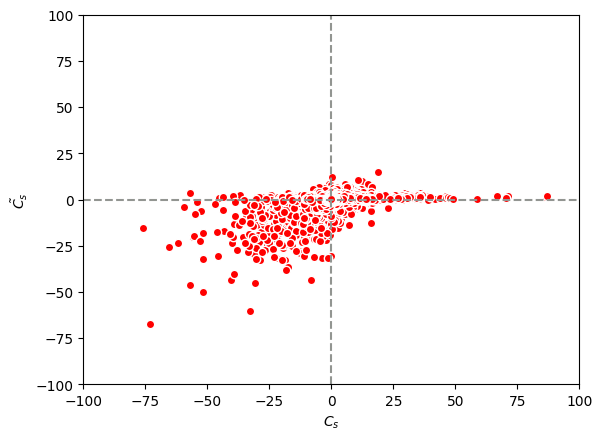

In [123]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation.png')

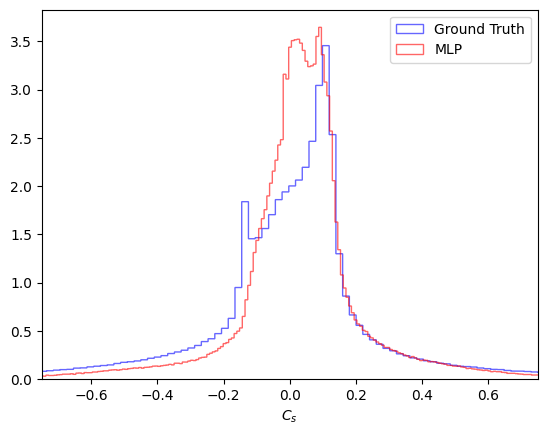

In [124]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density.png')